## Embedding Model

Now that we've established a baseline at `0.525` let's try to beat it. The first approach we'll use is embeddings. We'll be building on the work from: https://github.com/JoshVarty/LearningJax/blob/main/06_JaxEmbeddingTutorial.ipynb

In [69]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random

import tensorflow as tf
import jax
import jax.numpy as jnp
import functools
import optax

from flax.core import frozen_dict
from flax import struct
from flax import linen as nn
from flax.training import train_state

from matplotlib import pyplot as plt

tf.__version__

'2.7.0'

In [70]:
df = pd.read_csv("training_set_small.csv")
df

,hero0,hero1,hero2,hero3,hero4,hero5,hero6,hero7,hero8,hero9,radiant_win
0,62,14,106,28,11,10,85,112,2,48,True
1,27,129,48,9,36,8,62,1,126,120,True
2,14,105,1,88,22,89,87,129,39,59,False
3,30,22,35,26,96,58,120,7,21,11,True
4,52,54,123,81,25,107,26,8,96,6,False
...,...,...,...,...,...,...,...,...,...,...,...
10090,114,27,74,17,13,34,18,44,5,101,True
10091,69,128,31,35,1,93,106,2,26,87,True
10092,54,40,26,96,14,31,86,2,63,46,True
10093,44,22,54,13,84,119,8,26,49,6,True


In [71]:
# TODO(joshvarty): Move this to the data pre-processing stage.
df['radiant_win'] = df['radiant_win'].astype('float32')
df

,hero0,hero1,hero2,hero3,hero4,hero5,hero6,hero7,hero8,hero9,radiant_win
0,62,14,106,28,11,10,85,112,2,48,1.0
1,27,129,48,9,36,8,62,1,126,120,1.0
2,14,105,1,88,22,89,87,129,39,59,0.0
3,30,22,35,26,96,58,120,7,21,11,1.0
4,52,54,123,81,25,107,26,8,96,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10090,114,27,74,17,13,34,18,44,5,101,1.0
10091,69,128,31,35,1,93,106,2,26,87,1.0
10092,54,40,26,96,14,31,86,2,63,46,1.0
10093,44,22,54,13,84,119,8,26,49,6,1.0


In [72]:
# Create train/valid set
train_df = df.iloc[:9000]
test_df = df.iloc[9000:10000]

len(train_df), len(test_df)

(9000, 1000)

In [97]:
@struct.dataclass
class DotaModelConfig:
  """Global hyperparameters for our MovieLens Model"""
  heros_size: int = int(df.max().max() + 1)   # 1-indexed 
  emb_dim: int = 8
  dense_size_0: int = 32
  dense_size_1: int = 4
  out_size: int = 1
  num_epochs: int = 20
  batch_size: int = 1000
  lr: float = 0.01

In [135]:
class DotaModel(nn.Module):
  """A simple embedding model."""

  config: DotaModelConfig

  @nn.compact
  def __call__(self, heros):
    
    cfg = self.config
    
    hero0, hero1, hero2, hero3, hero4, hero5, hero6, hero7, hero8, hero9 = heros
            
    hero0_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero0')(hero0)
    hero1_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero1')(hero1)
    hero2_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero2')(hero2)
    hero3_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero3')(hero3)
    hero4_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero4')(hero4)

    hero5_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero5')(hero5)
    hero6_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero6')(hero6)
    hero7_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero7')(hero7)
    hero8_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero8')(hero8)
    hero9_embed = nn.Embed(num_embeddings=cfg.heros_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='hero9')(hero9)

    x = jnp.concatenate((hero0_embed, hero1_embed, hero2_embed, hero3_embed, hero4_embed, hero5_embed, hero6_embed, hero7_embed, hero8_embed, hero9_embed), axis=-1)
    x = jnp.squeeze(x)
        
    x = nn.Dense(cfg.dense_size_0, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.dense_size_1, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.out_size, kernel_init=nn.initializers.kaiming_uniform())(x)

    return x

In [99]:
@functools.partial(jax.jit)
def sigmoid(x):
   return 1/(1 + jnp.exp(-x))

In [127]:
@functools.partial(jax.jit, static_argnums=(0))
def apply_model(cfg, state, heros, radiant_win):
  
  def loss_fn(params):
    logits = DotaModel(cfg).apply({'params': params}, heros)
    logits = jnp.squeeze(logits)
    loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=radiant_win))
    return loss, logits
 
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  
  y_pred = jnp.round(sigmoid(logits))
  accuracy = jnp.mean(y_pred == radiant_win)
  return grads, loss, accuracy

In [128]:
@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [129]:
def train_epoch(cfg, state, train_df, rng):
  """Train for a single epoch."""
  train_df_size = len(train_df)
  steps_per_epoch = train_df_size // cfg.batch_size
  
  perms = jax.random.permutation(rng, train_df_size)
  perms = perms[:steps_per_epoch * cfg.batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, cfg.batch_size))
  
  epoch_loss = []
  epoch_accuracy = []

  for perm in perms:
    # x
    batch_hero0 = train_df.iloc[perm]['hero0'].values
    batch_hero1 = train_df.iloc[perm]['hero1'].values
    batch_hero2 = train_df.iloc[perm]['hero2'].values
    batch_hero3 = train_df.iloc[perm]['hero3'].values
    batch_hero4 = train_df.iloc[perm]['hero4'].values
    batch_hero5 = train_df.iloc[perm]['hero5'].values
    batch_hero6 = train_df.iloc[perm]['hero6'].values
    batch_hero7 = train_df.iloc[perm]['hero7'].values
    batch_hero8 = train_df.iloc[perm]['hero8'].values
    batch_hero9 = train_df.iloc[perm]['hero9'].values
    
    batch_heros = (batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4, 
                   batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9)
    
    # y
    batch_radiant_win = train_df.iloc[perm]['radiant_win'].values

    grads, loss, accuracy = apply_model(cfg, state, batch_heros, batch_radiant_win)
    state = update_model(state, grads)
    
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy

In [130]:
def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  model = DotaModel(config)
  
  # TODO(joshvarty): Probably don't need to use 5 here. Could use
  # config.batch_size though.
  hero_0_fake = jnp.zeros((5,1), jnp.int32)
  hero_1_fake = jnp.zeros((5,1), jnp.int32)
  hero_2_fake = jnp.zeros((5,1), jnp.int32)
  hero_3_fake = jnp.zeros((5,1), jnp.int32)
  hero_4_fake = jnp.zeros((5,1), jnp.int32)
  hero_5_fake = jnp.zeros((5,1), jnp.int32)
  hero_6_fake = jnp.zeros((5,1), jnp.int32)
  hero_7_fake = jnp.zeros((5,1), jnp.int32)
  hero_8_fake = jnp.zeros((5,1), jnp.int32)
  hero_9_fake = jnp.zeros((5,1), jnp.int32)
    
  heros = (hero_0_fake, hero_1_fake, hero_2_fake, hero_3_fake, hero_4_fake, hero_5_fake, hero_6_fake, hero_7_fake, hero_8_fake, hero_9_fake)
  
  # Pass fake values through our model to initialize the parameters
  params = model.init(rng, heros)['params']
  
  steps_per_epoch = len(train_df) // config.batch_size
  lr = optax.linear_onecycle_schedule(config.num_epochs * steps_per_epoch, config.lr)
  #tx = optax.adagrad(lr)
  tx = optax.adam(lr)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [139]:
def train_and_evaluate(config, train_df, test_df):
  rng = jax.random.PRNGKey(0)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)
  
  train_accuracies = []
  test_accuracies = []
  
  for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(config, state, train_df, rng)
    
    batch_hero0 = test_df['hero0'].values
    batch_hero1 = test_df['hero1'].values
    batch_hero2 = test_df['hero2'].values
    batch_hero3 = test_df['hero3'].values
    batch_hero4 = test_df['hero4'].values
    batch_hero5 = test_df['hero5'].values
    batch_hero6 = test_df['hero6'].values
    batch_hero7 = test_df['hero7'].values
    batch_hero8 = test_df['hero8'].values
    batch_hero9 = test_df['hero9'].values
    
    batch_heros = (batch_hero0, batch_hero1, batch_hero2, batch_hero3, batch_hero4, 
                   batch_hero5, batch_hero6, batch_hero7, batch_hero8, batch_hero9)

    batch_radiant_win = test_df['radiant_win'].values
    _, test_loss, test_accuracy = apply_model(config, state, batch_heros, batch_radiant_win)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.4f, test_loss: %.4f, test_accuracy: %.4f'
        % (epoch, train_loss, train_accuracy, test_loss, test_accuracy))
    
  return state, train_accuracies, test_accuracies

In [140]:
tf.config.experimental.set_visible_devices([], 'GPU')
config = DotaModelConfig()

state, train_accuracies, test_accuracies = train_and_evaluate(config, train_df, test_df)

epoch:  1, train_loss: 0.6934, train_accuracy: 0.5033, test_loss: 0.6933, test_accuracy: 0.5120
epoch:  2, train_loss: 0.6877, train_accuracy: 0.5400, test_loss: 0.6930, test_accuracy: 0.5260
epoch:  3, train_loss: 0.6782, train_accuracy: 0.5727, test_loss: 0.6943, test_accuracy: 0.5170
epoch:  4, train_loss: 0.6595, train_accuracy: 0.6192, test_loss: 0.7010, test_accuracy: 0.5090
epoch:  5, train_loss: 0.6203, train_accuracy: 0.6662, test_loss: 0.7436, test_accuracy: 0.5070
epoch:  6, train_loss: 0.5648, train_accuracy: 0.7158, test_loss: 0.7935, test_accuracy: 0.5140
epoch:  7, train_loss: 0.4926, train_accuracy: 0.7750, test_loss: 0.8547, test_accuracy: 0.5280
epoch:  8, train_loss: 0.4069, train_accuracy: 0.8321, test_loss: 0.9468, test_accuracy: 0.5210
epoch:  9, train_loss: 0.3265, train_accuracy: 0.8784, test_loss: 1.0726, test_accuracy: 0.5360
epoch: 10, train_loss: 0.2510, train_accuracy: 0.9194, test_loss: 1.1727, test_accuracy: 0.5310
epoch: 11, train_loss: 0.1897, train_acc

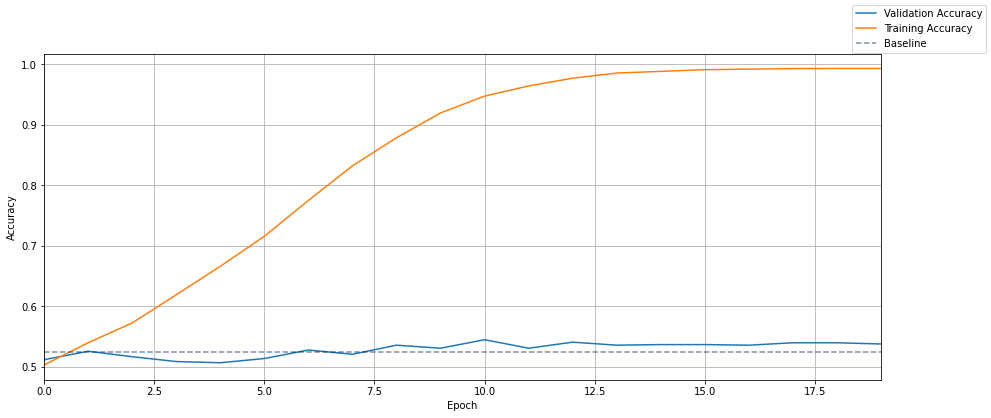

In [142]:
epoch_iota = np.arange(len(train_accuracies))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(epoch_iota, test_accuracies, label='Validation Accuracy')
ax.plot(epoch_iota, train_accuracies, label='Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=0, right=epoch_iota[-1])
baseline_accuracy = 0.525 # From previous notebook.
ax.axhline(baseline_accuracy, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

- Some very powerful overfitting at play here. On the bright side that means the model can learn **something**.
- Test/Validation accuracy seems to actually improve over the baseline, even with this overfitting so that's promising!

Our next step would be to get a larger dataset. Let's try to collect 100,000 games on which we can train.